# Supervised Deep Learning for RSSI Fingerprint in indoor Localization

## Introduction

Indoor localization is the process of obtaining the location of a user or device in an indoor environment, possibly thanks to the proliferation of mobile/wearable devices with wireless communication capabilities.
These systems are called Indoor Positioning Systems (IPS)

RSSI (Received Signal Strength Indicator) is a common technique used for indoor localization which leverage BLE (Bluetooth Low Energy) beacons to estimate the distance of the receiver from the antenna. Using more than 3 RSSI measurements, it is possible to estimate the position of the receiver using multilateration.

BLE beacons are small transmitters that continuously broadcast their id to nearby devices. They are usually more accurate than WiFi but deployment and maintenance are more difficult.

RSSI Fingerprint is a technique where RSSI data is collected from many positions in the indoor environment. Each RSSI sample is annotated with exact coordinates (or location in our case), in order to create radio map of the environment. A model is then used to estimate the position.

In the offline phase someone is in charge of moving in the environment to report the exact current position and collect the exact fingerprint in that position.

In the online phase the user is in the environment and his position is estimated by taking the closest fingerprint. ML methods can be used to estimate in a more robust way the position. An often used method is KNN (K-Nearest Neighbors) which takes the K closest fingerprints and estimates the position as the average of the K positions.

## Dataset

For this project I'm going to use the Waldo dataset provided by Mehdi Mohammadi and Ala Al-Fuqaha, {mehdi.mohammadi, ala-alfuqaha}@wmich.edu, \Department of Computer Science, Western Michigan University.

The dataset was created using the RSSI readings of an array of 13 ibeacons in the first floor of the Waldo Library, Western Michigan University.

The data contains the location (label column), a timestamp, followed by RSSI readings of 13 iBeacons. RSSI measurements are negative values. Bigger RSSI values indicate closer proximity to a given iBeacon. For out of range iBeacons the RSSI is indicated by -200. The location related to RSSI readings are combined in one column consisting a letter for the column and a number for the row of the position. The following figure depicts the layout of the library and the location of the iBeacons.

<img src="Data/iBeacon_Layout.jpg" width="700" height="500">

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load Data

data = pd.read_csv('Data/iBeacon_RSSI_Labeled.csv')
data.head()

,location,date,b3001,b3002,b3003,b3004,b3005,b3006,b3007,b3008,b3009,b3010,b3011,b3012,b3013
0,O02,10-18-2016 11:15:21,-200,-200,-200,-200,-200,-78,-200,-200,-200,-200,-200,-200,-200
1,P01,10-18-2016 11:15:19,-200,-200,-200,-200,-200,-78,-200,-200,-200,-200,-200,-200,-200
2,P01,10-18-2016 11:15:17,-200,-200,-200,-200,-200,-77,-200,-200,-200,-200,-200,-200,-200
3,P01,10-18-2016 11:15:15,-200,-200,-200,-200,-200,-77,-200,-200,-200,-200,-200,-200,-200
4,P01,10-18-2016 11:15:13,-200,-200,-200,-200,-200,-77,-200,-200,-200,-200,-200,-200,-200


In [3]:
data.describe()

,b3001,b3002,b3003,b3004,b3005,b3006,b3007,b3008,b3009,b3010,b3011,b3012,b3013
count,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000
mean,-197.825352,-156.623944,-175.533099,-164.534507,-178.378169,-175.063380,-195.637324,-191.970423,-197.145070,-197.442254,-197.748592,-197.233803,-196.065493
std,16.259105,60.217747,49.452958,56.523261,47.175799,49.596627,22.880980,30.733742,19.160207,17.741632,16.852535,18.541088,22.053924
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
25%,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
50%,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
75%,-200.000000,-78.000000,-200.000000,-80.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
max,-67.000000,-59.000000,-56.000000,-56.000000,-60.000000,-62.000000,-58.000000,-56.000000,-55.000000,-61.000000,-59.000000,-60.000000,-59.000000


In [4]:
data.info() # No missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1420 entries, 0 to 1419
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   location  1420 non-null   object
 1   date      1420 non-null   object
 2   b3001     1420 non-null   int64 
 3   b3002     1420 non-null   int64 
 4   b3003     1420 non-null   int64 
 5   b3004     1420 non-null   int64 
 6   b3005     1420 non-null   int64 
 7   b3006     1420 non-null   int64 
 8   b3007     1420 non-null   int64 
 9   b3008     1420 non-null   int64 
 10  b3009     1420 non-null   int64 
 11  b3010     1420 non-null   int64 
 12  b3011     1420 non-null   int64 
 13  b3012     1420 non-null   int64 
 14  b3013     1420 non-null   int64 
dtypes: int64(13), object(2)
memory usage: 166.5+ KB


In [5]:
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(by='date').reset_index(drop=True) # Sort by date

In [6]:
def convert_location(location):
    '''
    Convert location to x, y coordinates:
    First letter is x, numbers are y
    Example: 'A01' -> (1, 1)
    '''
    return (float(ord(location[0])) - 64, float(int(location[1:])))

def convert_coordinates(x, y):
    '''
    Convert x, y coordinates to location:
    x is the first letter, y is the number
    Example: (1, 1) -> 'A01'
    '''
    return chr(int(x) + 64) + str(int(y)).zfill(2)


data['coordinates'] = data['location'].apply(convert_location)

def distance(a, b):
    '''
    Compute the Euclidean Distance between two points
    '''
    return np.linalg.norm(np.array(a) - np.array(b))

def accuracy_in_distance(y_pred_coordinates, y_coordinates):
    '''
    Compute the average Euclidean Distance between two lists of points
    '''
    return np.mean([distance(a, b) for a, b in zip(y_pred_coordinates, y_coordinates)])

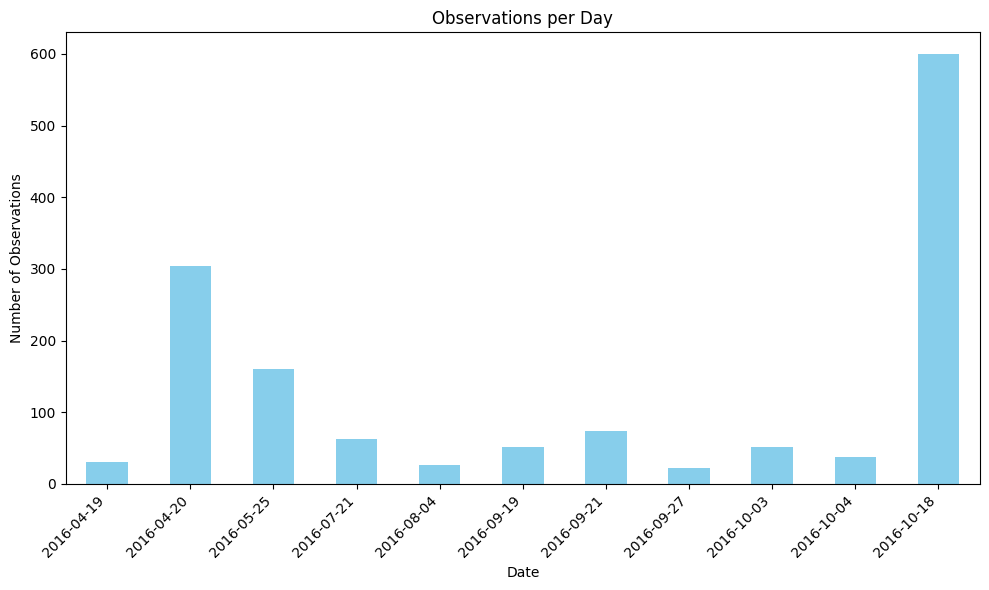

In [7]:
data['day'] = data['date'].dt.date # I want to get only the day
obs_per_day = data.groupby('day').size() # Group #obs per day to visualize it

# Plotting the histogram
plt.figure(figsize=(10, 6))
obs_per_day.plot(kind='bar', color='skyblue')
plt.title('Observations per Day')
plt.xlabel('Date')
plt.ylabel('Number of Observations')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()

The plot above is just to give me an idea of when the instances were collected. I wanted to plot this also to see if I could adopt a split strategy based on the day, like a keep one day out or just excluding the last days.
However, keeping the last day out for validation and testing isn't a good idea in my opinion as it would means to keep out of the training set too much observations.

In [8]:
features_names = data.columns.drop(['location','date','coordinates','day'])

X = data[features_names] # Features
y = data['location'] # Labels


## Base Model

### Classification

I fit a KNN classifier trying to predict target location which is treated like a class

K-Nearest Neighbors (KNN) is a supervised machine learning algorithm used for classification tasks. KNN is a type of instance-based learning, where the algorithm makes predictions based on the majority class or average value of the k-nearest data points in the feature space.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [10]:
# Training pipeline:

K = list(range(1, 16)) # k = 1, 2, 3, ..., 10
acc = []
for k in K:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)

    # Train the classifier on the scaled training data
    knn_classifier.fit(X_train, y_train)

    # Make predictions on the scaled test data
    y_pred = knn_classifier.predict(X_valid)

    # Calculate accuracy
    accuracy = accuracy_score(y_valid, y_pred)
    acc.append(accuracy)
    


The value of 'k' is a crucial hyperparameter in KNN, and it determines how many neighbors are considered when making predictions. The choice of 'k' can impact the model's performance.

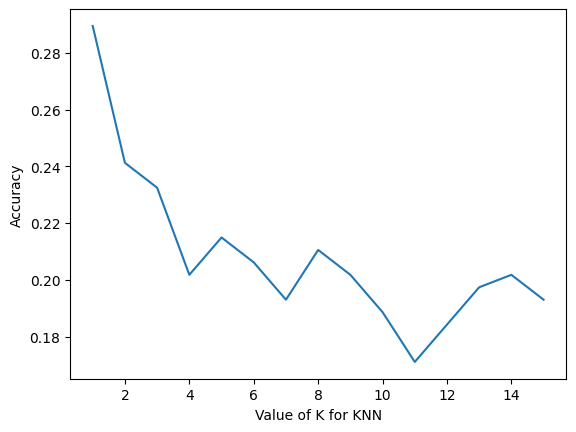

In [11]:
# Plot the accuracy for different values of k
import matplotlib.pyplot as plt
plt.plot(K, acc)
plt.xlabel('Value of K for KNN')
plt.ylabel('Accuracy')
plt.show()

In [12]:
# It is never a good option to choose k=1, because it will overfit the training data.

# Baseline model: k=1, we will train it on whole training data
k = 2
baseline = KNeighborsClassifier(n_neighbors=k)
baseline.fit(X, y)

# Results on training data
y_pred = baseline.predict(X)
baseline_accuracy = accuracy_score(y, y_pred)
print(f"Baseline accuracy: {baseline_accuracy:.2f}")


Baseline accuracy: 0.49


In [13]:
# Calculate accuracy in terms of distance
y_pred_coordinates = [convert_location(location) for location in y_pred]
y_coordinates = [convert_location(location) for location in y]
y_pred_coordinates[0], y_coordinates[0]




((9.0, 1.0), (9.0, 1.0))

###  Regression with target coordinates

I transform the target variable into coordinates x and y, then I fit two different LightGBM regressors. One for each coordinate x and y

In [14]:
# Get coordinates of target variable
y_x = [convert_location(loc)[0] for loc in y]
y_y = [convert_location(loc)[1] for loc in y]
Y = [[np.float32(x), np.float32(y)] for x, y in zip(y_x, y_y)]
Y = np.array(Y)
Y

array([[ 9.,  1.],
       [ 9.,  1.],
       [ 9.,  1.],
       ...,
       [16.,  1.],
       [16.,  1.],
       [15.,  2.]], dtype=float32)

In [15]:
# Random split
X_train, X_test, Y_train,Y_test = train_test_split(X, Y, test_size=0.3, shuffle=False, random_state=42)
X_valid, X_test, Y_valid, Y_test = train_test_split(X_test, Y_test, test_size=0.5, shuffle=False, random_state=42)


LightGBM (Light Gradient Boosting Machine) is a gradient boosting framework that is designed for distributed and efficient training of large datasets. It is an open-source machine learning library developed by Microsoft and is widely used for various machine learning tasks

In [16]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error

modelGBx = HistGradientBoostingRegressor()
modelGBy = HistGradientBoostingRegressor()

# Fitting the two models
print("Fitting model x...")
modelGBx.fit(X_train, Y_train[:,0])
print("Fitting model y...")
modelGBy.fit(X_train, Y_train[:,1])

# Prediction
predGBx = modelGBx.predict(X_valid)
predGBy = modelGBy.predict(X_valid)

predGBY = [[np.float32(x), np.float32(y)] for x, y in zip(predGBx, predGBy)]

# Evaluation
print(f"MSE: {mean_squared_error(Y_valid, predGBY)}")

Fitting model x...
Fitting model y...
MSE: 2.372178792953491


In [17]:
# Fitting the two models
print("Fitting model x...")
modelGBx.fit(X, Y[:,0])
print("Fitting model y...")
modelGBy.fit(X, Y[:,1])

# Prediction
predGBx = modelGBx.predict(X)
predGBy = modelGBy.predict(X)

predGBY = [[np.float32(x), np.float32(y)] for x, y in zip(predGBx, predGBy)]

# Evaluation
print(f"MSE: {mean_squared_error(Y, predGBY)}")

Fitting model x...
Fitting model y...
MSE: 1.5480246543884277


## Exploring deep networks

### MLP

In [18]:
data = data.sort_values(by='date')

X = data[features_names]
y = data['location']

# Get coordinates of target variable
y_x = [convert_location(loc)[0] for loc in y]
y_y = [convert_location(loc)[1] for loc in y]
Y = [[np.float32(x), np.float32(y)] for x, y in zip(y_x, y_y)]
Y = np.array(Y)
Y


array([[ 9.,  1.],
       [ 9.,  1.],
       [ 9.,  1.],
       ...,
       [16.,  1.],
       [16.,  1.],
       [15.,  2.]], dtype=float32)

I decided to adopt a simple strategy to split the data into train, validation and test set which is the standard single division of the whole data into the 3 different sets.

This choice is motivated by how the data is collected. The user move in the environment with his reading device. Every 3 seconds, the user collect the RSSI reading and the position. Collecting data every three seconds means that observations collected consecutively could be extremely similar or the same. I don't want the same observation to be both on the train set and the test set.

Considering this fact, I leverage the temporal information associated to every observation and I chose to divide the data into the three sets accordingly to their timestamp. Keeping older observations in the training set and putting the latest observations in the test set.


In [19]:

# Split (It's not random because I want older observations in the training set and latest observations in the test set, accordingly with the temporal information)
X_train, X_test, Y_train,Y_test = train_test_split(X, Y, test_size=0.3, shuffle=False, random_state=42)
X_valid, X_test, Y_valid, Y_test = train_test_split(X_test, Y_test, test_size=0.5, shuffle=False, random_state=42)

print(f"Training set size: X: {len(X_train)} Y: {len(Y_train)}")
print(f"Validation set size: X: {len(X_valid)} Y: {len(Y_valid)}")
print(f"Test set size: X: {len(X_test)} Y: {len(Y_test)}")

Training set size: X: 994 Y: 994
Validation set size: X: 213 Y: 213
Test set size: X: 213 Y: 213


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Define the dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, target):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.target = torch.tensor(target, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        return x, y
    
# Define the deep neural network model
class DeepNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DeepNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Define the input size, hidden size, and output size of the network
input_size = X.shape[1]  # Number of features (e.g., RSSI readings)
hidden_size = 64  # Number of neurons in the hidden layer
output_size = 2  # Number of coordinates in the target

params = {
    "num_epochs": 200,
    "lr": 0.001,
    "batch_size": 32
}

torch.manual_seed(42)
# Instantiate the model, loss function, and optimizer
model = DeepNet(input_size, hidden_size, output_size)
criterion = nn.MSELoss()  
optimizer = optim.Adam(model.parameters(), lr=params["lr"])

# Create a custom dataset and DataLoader for training
train_dataset = CustomDataset(np.array(X_train), np.array(Y_train))
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)

# Create a custom dataset and DataLoader for validation
val_dataset = CustomDataset(np.array(X_valid), np.array(Y_valid))
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

hist = {"Train Loss": [],
        "Validation Loss": []}
# Training the model
num_epochs = 200
for epoch in tqdm(range(num_epochs)):
    for inputs, labels in train_dataloader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    hist["Train Loss"].append(loss.item())
    
    # Validation Loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_labels in val_dataloader:
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_labels).item()

    # Calculate average validation loss
    val_loss /= len(val_dataloader)
    hist["Validation Loss"].append(val_loss)

# Evaluation of the predictions

with torch.no_grad():
    model.eval()
    predictions = model(torch.tensor(np.array(X_valid), dtype=torch.float32))
    mse = mean_squared_error(np.array(Y_valid), predictions.numpy())
print(f'Mean Squared Error on Validation Data: {mse:.4f}')


100%|██████████| 200/200 [00:02<00:00, 81.50it/s]

Mean Squared Error on Validation Data: 4.3374


In [21]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

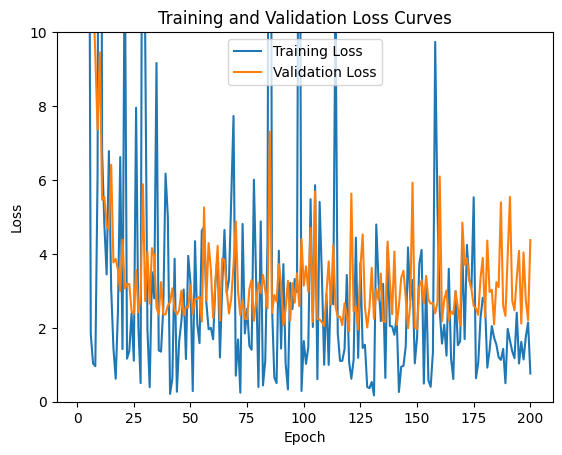

In [22]:
def plot_train_loss(hist, p):
    """ 
    input:
        hist    <- dict containing the following keys
                    "Train Loss": training loss for each epoch
                    "Validation Loss": validation loss for each epoch
        p       <- dict containing the following keys
                    "num_epochs" numbber of epochs
    """
    epochs_range = range(1, p["num_epochs"] + 1)
    plt.plot(epochs_range, hist["Train Loss"], label='Training Loss')
    plt.plot(epochs_range, hist["Validation Loss"], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylim(0, 10)
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.show()
    return

plot_train_loss(hist, params)

Can I obtain better results? I test different values for the batch size, the learning rate, and the number of epochs.

If I increase the batch size I expect faster computation efficiency (but higher RAM usage) and a smoother train/validation loss curve. 

If I decrease the learning rate I expect a slower training but with smaller steps during backpropagation I may have higher chances of getting in a deeper local minima

I may choose to decrease the number of epochs to avoid issues like overfitting

In [23]:
def TrainPipeLine(model, train_dataset, val_dataset, p, plot_results=True):
    path = "/Users/giofratti/Documents/Giorgio/Università/Master/1st Year/2nd Semester/Ambient Intelligence/Project/Models/"
    '''
    Input: 
        model <- pyTorch model
        train_dataloader
        validation_dataloader
        p <- dictionary with hyper parameters:
            "num_epochs": number of epochs
            "lr": learning rate
        plot_results <- if True plot train/validation loss curves
        
    Output:
        model <- optimized pyTorch model
        hist <- dict containing the following keys
            "Train Loss": training loss for each epoch
            "Validation Loss": validation loss for each epoch
            "MSE": Final MSE on validation dataset
    '''
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
    
    criterion = nn.MSELoss()  # Mean Squared Error Loss
    optimizer = optim.Adam(model.parameters(), lr=p["lr"])
    
    hist = {"Train Loss": [],
            "Validation Loss": []}
    
    # Training the model
    num_epochs = p["num_epochs"]
    for epoch in tqdm(range(num_epochs)):
        for inputs, labels in train_dataloader:
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        hist["Train Loss"].append(loss.item())
        
        # Validation Loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for val_inputs, val_labels in val_dataloader:
                val_outputs = model(val_inputs)
                val_loss += criterion(val_outputs, val_labels).item()
                   
        # Calculate average validation loss
        val_loss /= len(val_dataloader)
        if (epoch > 1 and val_loss < min(hist["Validation Loss"])):
            torch.save(model, path+f"{model.__class__.__name__}.pth")
        hist["Validation Loss"].append(val_loss)

    # Evaluation of the predictions

    with torch.no_grad():
        model.eval()
        predictions = model(torch.tensor(np.array(X_valid), dtype=torch.float32))
        hist["MSE"] = min(hist['Validation Loss'])
    print(f'Mean Squared Error on Validation Data: {hist["MSE"]:.4f}')
    if plot_results:
        plot_train_loss(hist, params)

    return model, hist, predictions

100%|██████████| 800/800 [00:14<00:00, 53.59it/s]


Mean Squared Error on Validation Data: 1.7316


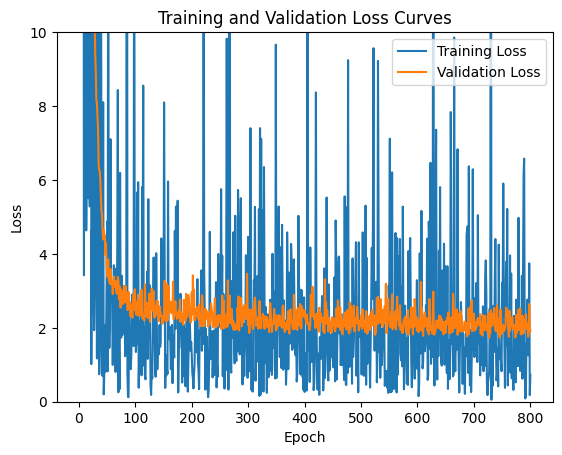

In [24]:
params["num_epochs"]=800
params["lr"]=0.0001
params["batch_size"]=16

torch.manual_seed(42)
MLP = DeepNet(input_size, hidden_size, output_size)
MLP, hist, val_pred = TrainPipeLine(MLP, train_dataset, val_dataset, params)


We are still far from our goal which is a mse of 1.54.
We can try to get better performances by increasing the complexity of the model, like adding more layers or neurons

In [25]:
# try to play with different number of layers/neurons

class DeepNet_v2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size): # 13 64 2
        super(DeepNet_v2, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size*2)
        self.fc3 = nn.Linear(hidden_size*2, hidden_size) 
        self.fc4 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)        
        return x

100%|██████████| 200/200 [00:02<00:00, 68.99it/s]

Mean Squared Error on Validation Data: 1.4762


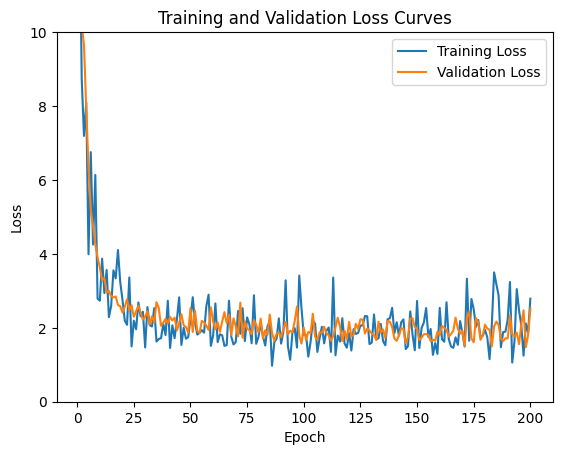

Best MSE: 1.4761531352996826


In [26]:
params["num_epochs"]=200
params["lr"]=0.0001
params["batch_size"]=64
hidden_size=128

torch.manual_seed(42)
MLP2 = DeepNet_v2(input_size, hidden_size, output_size)
MLP2, hist, val_pred = TrainPipeLine(MLP2, train_dataset, val_dataset, params)
best = min(hist['Validation Loss'])
print(f"Best MSE: {best}")

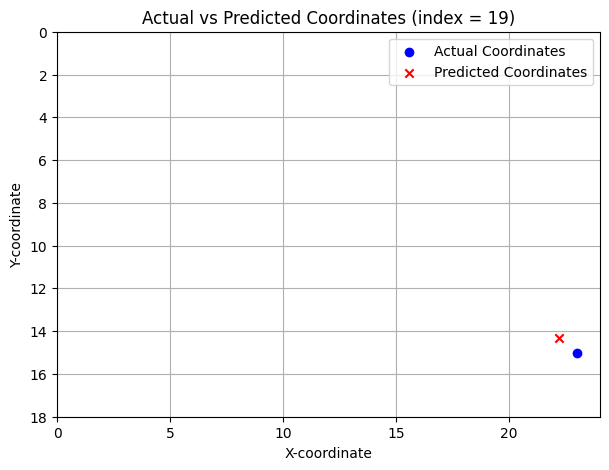

In [27]:
import random

def visualize_prediction(actual, pred, index=None):
    
    if (index==None):
        index = random.randint(0, len(actual) -1)
    
    plt.figure(figsize=(7, 5))
    plt.scatter(Y_valid[index,0], Y_valid[index,1], c='blue', label='Actual Coordinates')
    plt.scatter(val_pred[index,0], val_pred[index,1], c='red', marker='x', label='Predicted Coordinates')

    
    plt.title(f'Actual vs Predicted Coordinates (index = {index})')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.xlim(0,24)
    plt.ylim(0,18)
    plt.legend()

    plt.gca().invert_yaxis() # more consinstent visualization according to the reference system of the Waldo library

    plt.grid(True)
    plt.show()
    return

visualize_prediction(Y_valid, val_pred, index=19)

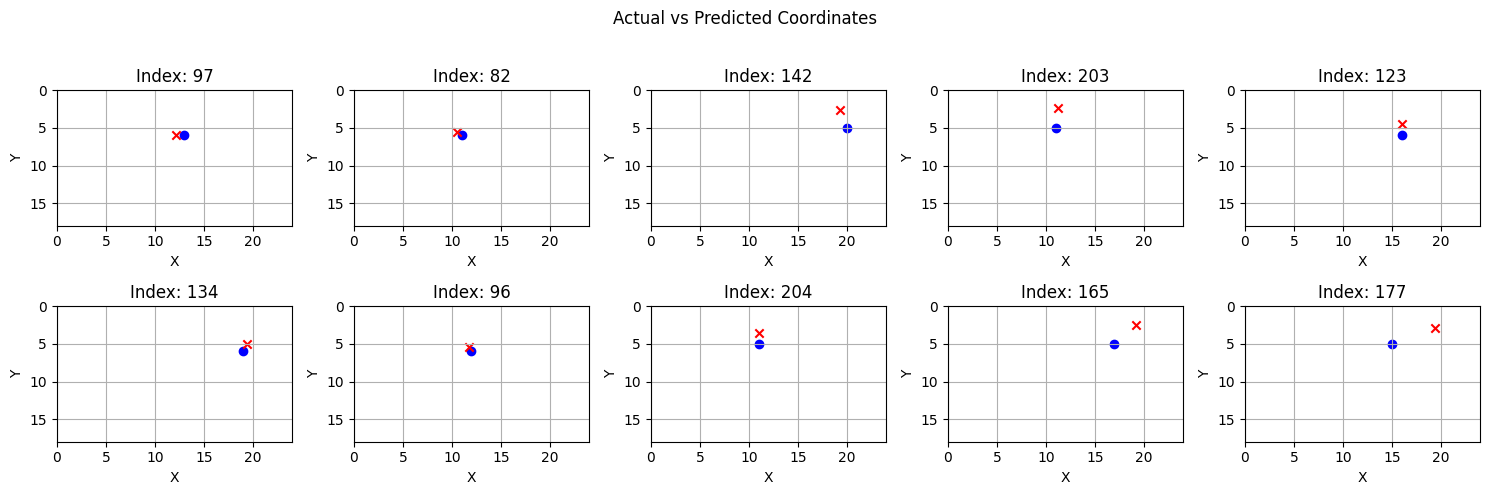

In [28]:

def visualize_ten_predictions(actual, pred):
    # Create a 2x5 grid of subplots
    fig, axs = plt.subplots(2, 5, figsize=(15, 5))
    fig.suptitle('Actual vs Predicted Coordinates')

    for i in range(10):
        
        # Random index
        index = random.randint(0, len(actual) - 1)

        # Subplot position
        row = i // 5
        col = i % 5

        
        axs[row, col].scatter(actual[index, 0], actual[index, 1], c='blue', label='Actual Coordinates')
        axs[row, col].scatter(pred[index, 0], pred[index, 1], c='red', marker='x', label='Predicted Coordinates')

        
        axs[row, col].set_title(f'Index: {index}')
        axs[row, col].set_xlabel('X')
        axs[row, col].set_ylabel('Y')
        axs[row, col].set_xlim(0, 24)
        axs[row, col].set_ylim(0, 18)
        axs[row, col].invert_yaxis()
        axs[row, col].grid(True)

    # adjust titles position
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    plt.show()
    return

visualize_ten_predictions(Y_valid, val_pred)


### CNN

I finally reached the performance of the baseline on the validation set.

But now, I want to create a better model by incorporating the spatial informations given by the beacons position.

My idea is to generate for every observation an image of an "heatmap" where I will have brighter pixels the more powerful the signal of a beacon is. The pixels will lighten up in the correspondence of the real beacons positions.

Then, I want to feed these images into a Convolutional Neural Network which are commonly know to capture spatial relationships.

In [29]:
beacon_coords = {"b3001": (5, 9), 
                 "b3002": (9, 4), 
                 "b3003": (13, 4), 
                 "b3004": (18, 4), 
                 "b3005": (9, 7), 
                 "b3006": (13, 7), 
                 "b3007": (18, 7), 
                 "b3008": (9, 10), 
                 "b3009": (2, 15), 
                 "b3010": (9, 15), 
                 "b3011": (13, 15), 
                 "b3012": (18, 15), 
                 "b3013": (22, 15),}

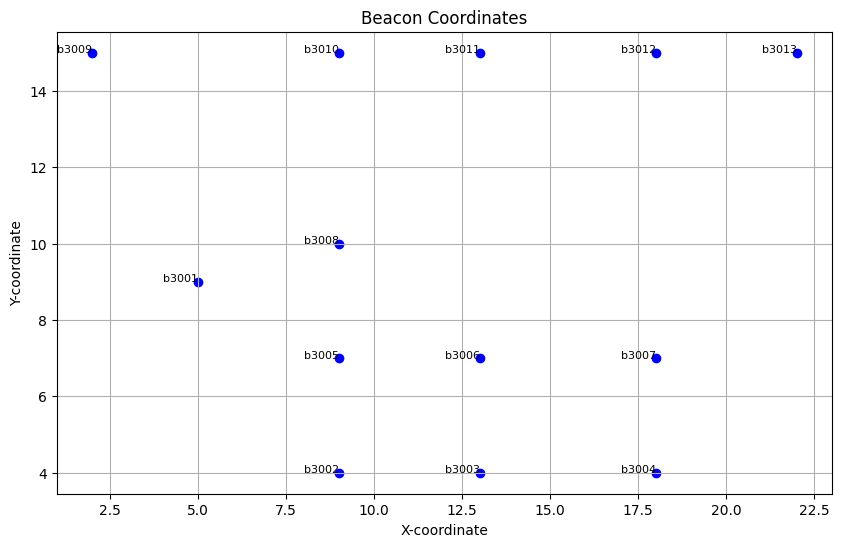

In [30]:

x_coords, y_coords = zip(*beacon_coords.values())

# Plot the coordinates
plt.figure(figsize=(10, 6))
plt.scatter(x_coords, y_coords, color='blue', marker='o')

# Annotate the points with beacon names
for beacon, (x, y) in beacon_coords.items():
    plt.text(x, y, beacon, fontsize=8, ha='right')


plt.title('Beacon Coordinates')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.grid(True)

plt.show()

In [31]:
# Y.max(0) # (23, 15)

# I want to create 24x16 images 
def visualize_obs(obs):
    # Visualize the matrix using a 'heatmap'
    plt.imshow(obs, cmap='viridis')
    plt.title('RSSI map')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.xlim(0,23.5)
    plt.ylim(0,15.5)
    plt.colorbar(label='Value')
    plt.gca().invert_yaxis()
    plt.show()
    return


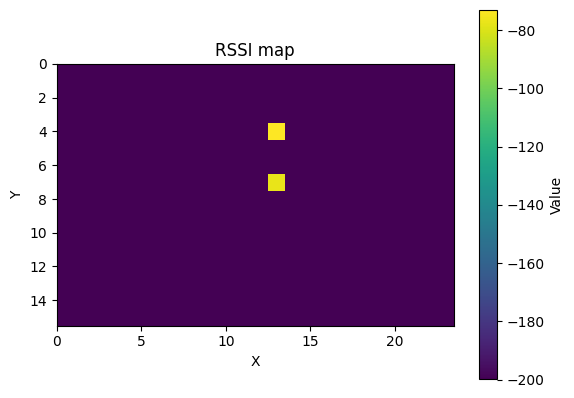

In [32]:
images = []

for index, row in data.iterrows():
    # Create a 24x16 matrix filled with -200
    matrix = torch.full((16, 24), -200)
    
    # Fill the matrix with beacon coordinates
    for beacon, coords in beacon_coords.items():
        x, y = coords
        matrix[y, x] = row[beacon]
    
    images.append(torch.Tensor(matrix))

data['images'] = images

visualize_obs(data['images'].iloc[180])

In [33]:
data = data.sort_values(by='date')

X = data['images']
y = data['location']

# Get coordinates of target variable
y_x = [convert_location(loc)[0] for loc in y]
y_y = [convert_location(loc)[1] for loc in y]
Y = [[np.float32(x), np.float32(y)] for x, y in zip(y_x, y_y)]
Y = np.array(Y)
Y

# Split (It's not random because I want older observations in the training set and latest observations in the test set, accordingly with the temporal information)
X_train, X_test, Y_train,Y_test = train_test_split(X, Y, test_size=0.3, shuffle=False, random_state=42)
X_valid, X_test, Y_valid, Y_test = train_test_split(X_test, Y_test, test_size=0.5, shuffle=False, random_state=42)

print(f"Training set size: X: {len(X_train)} Y: {len(Y_train)}")
print(f"Validation set size: X: {len(X_valid)} Y: {len(Y_valid)}")
print(f"Test set size: X: {len(X_test)} Y: {len(Y_test)}")

Training set size: X: 994 Y: 994
Validation set size: X: 213 Y: 213
Test set size: X: 213 Y: 213


In [34]:
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 4 * 6, 128)  # Adjusted the input size based on the actual output size
        self.fc2 = nn.Linear(128, 2)  # Assuming 2D coordinates for the target variable

    def forward(self, x):
        x = x[:, None, :, :]  # Reshape input to (batch_size, channels, height, width)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = nn.Flatten(start_dim=1, end_dim=-1)(x)  # Adjusted the flatten size based on the actual output size
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [35]:
def TrainCNN(model, train_dataset, val_dataset, p, plot_results=True):
    path = "/Users/giofratti/Documents/Giorgio/Università/Master/1st Year/2nd Semester/Ambient Intelligence/Project/Models/"
    '''
    Input: 
        model <- pyTorch model
        train_dataloader
        validation_dataloader
        p <- dictionary with hyper parameters:
            "num_epochs": number of epochs
            "lr": learning rate
        plot_results <- if True plot train/validation loss curves
        
    Output:
        model <- optimized pyTorch model
        hist <- dict containing the following keys
            "Train Loss": training loss for each epoch
            "Validation Loss": validation loss for each epoch
            "MSE": Final MSE on validation dataset
    '''
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True, pin_memory=True)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
    
    device = torch.device('mps')
    model.to(device)
    
    criterion = nn.MSELoss()  # Mean Squared Error Loss
    optimizer = optim.Adam(model.parameters(), lr=p["lr"])
    
    hist = {"Train Loss": [],
            "Validation Loss": []}
    
    # Training the model
    num_epochs = p["num_epochs"]
    for epoch in tqdm(range(num_epochs)):
        for inputs, labels in train_dataloader:
            
            inputs, labels = inputs.to(device), labels.to(device)
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        hist["Train Loss"].append(loss.item())
        
        # Validation Loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for val_inputs, val_labels in val_dataloader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss += criterion(val_outputs, val_labels).item()

        # Calculate average validation loss
        val_loss /= len(val_dataloader)
        if (epoch > 1 and val_loss < min(hist["Validation Loss"])):
            torch.save(model, path+f"{model.__class__.__name__}.pth")
        hist["Validation Loss"].append(val_loss)

    # Evaluation of the predictions
    print(f"Final MSE on  validation set: {hist['Validation Loss'][-1]}")
    hist['MSE'] = min(hist['Validation Loss'])
    if plot_results:
        plot_train_loss(hist, params)

    return model, hist, predictions

In [36]:
params['batch_size'] = 16
params['num_epochs'] = 300


/var/folders/fr/_8m6478904jb8v5wdgyfm_j80000gn/T/ipykernel_79780/1006013634.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(data, dtype=torch.float32)
100%|██████████| 300/300 [02:07<00:00,  2.36it/s]

Final MSE on  validation set: 1.8822036981582642


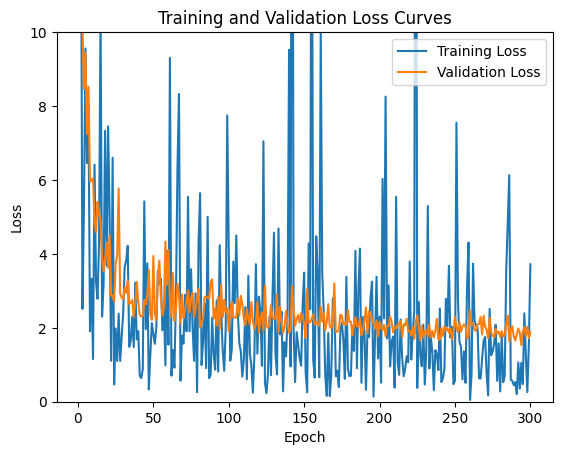

In [37]:
train_dataset = CustomDataset(torch.stack(list(X_train)), np.array(Y_train))
val_dataset = CustomDataset(torch.stack(list(X_valid)), np.array(Y_valid))

torch.manual_seed(42)
CNN_1 = ConvNet()
CNN_1, hist, val_pred = TrainCNN(CNN_1, train_dataset, val_dataset, params)

I obtain more or less the same performance of the MLP. I try to play with the hyperparameters and the CNN architecture in order to obtain a better model

In [38]:
class ConvNet_v2(nn.Module):
    def __init__(self):
        super(ConvNet_v2, self).__init__()
        self.conv1 = nn.Conv2d(1, 256, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(256)
        self.conv2 = nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 4 * 6, 256)
        self.fc2 = nn.Linear(256, 2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x[:, None, :, :]
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = nn.Flatten(start_dim=1, end_dim=-1)(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


With respect to the classic architecture, when increasing the complexity of the model, we increase the chance of overfitting.

To prevent this is usually a good choice to put into the model architecture some "tricks":
- Batch Normalization: It normalizes the intermediate outputs of each layer within a batch during training, making the optimization process more stable and faster.
- Dropout layer: The dropout layer is a layer used in the construction of neural networks to prevent overfitting. In this process, individual nodes are excluded in various training runs using a probability, as if they were not part of the network architecture at all. By using the dropout layer, neurons can no longer rely on the nodes from previous or subsequent layers, since they cannot assume that they even exist in that particular training run. This leads to neurons, provably, recognizing more fundamental structures in data that do not depend on the existence of individual neurons. These dependencies actually occur relatively frequently in regular neural networks, as this is an easy way to quickly reduce the loss function and thereby quickly get closer to the goal of the model.

In [39]:
params['lr'] = 0.001
params['batch_size'] = 16
params['num_epochs'] = 200

/var/folders/fr/_8m6478904jb8v5wdgyfm_j80000gn/T/ipykernel_79780/1006013634.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(data, dtype=torch.float32)
100%|██████████| 200/200 [02:04<00:00,  1.61it/s]

Final MSE on  validation set: 1.5507557392120361


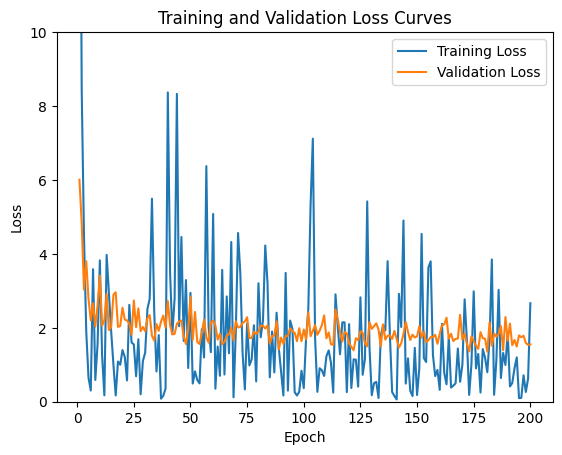

In [40]:
train_dataset = CustomDataset(torch.stack(list(X_train)), np.array(Y_train))
val_dataset = CustomDataset(torch.stack(list(X_valid)), np.array(Y_valid))

torch.manual_seed(42)
CNN_2 = ConvNet_v2()
CNN_2, hist, val_pred = TrainCNN(CNN_2, train_dataset, val_dataset, params)

In [41]:
DN = torch.load("/Users/giofratti/Documents/Giorgio/Università/Master/1st Year/2nd Semester/Ambient Intelligence/Project/Models/DeepNet.pth")
DN2 = torch.load("/Users/giofratti/Documents/Giorgio/Università/Master/1st Year/2nd Semester/Ambient Intelligence/Project/Models/DeepNet_v2.pth")
CN = torch.load("/Users/giofratti/Documents/Giorgio/Università/Master/1st Year/2nd Semester/Ambient Intelligence/Project/Models/ConvNet.pth")
CN2 = torch.load("/Users/giofratti/Documents/Giorgio/Università/Master/1st Year/2nd Semester/Ambient Intelligence/Project/Models/ConvNet_v2.pth")

## Evaluation on Test Set

In [42]:
X_image = data['images']
X_features = data[features_names]
Y_test = np.array(list(data['coordinates'].iloc[X_test.index]))
X_features_test = X_features.iloc[X_test.index]
X_image_test = X_image.iloc[X_test.index]

In [43]:
test_data_features = CustomDataset(np.array(X_features_test), Y_test)
test_data_images = CustomDataset(torch.stack(list(X_image_test)), Y_test)
features_dl = torch.utils.data.DataLoader(test_data_features, batch_size=len(test_data_features), shuffle=False)
images_dl = torch.utils.data.DataLoader(test_data_images, batch_size=len(test_data_images), shuffle=False)

/var/folders/fr/_8m6478904jb8v5wdgyfm_j80000gn/T/ipykernel_79780/1006013634.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(data, dtype=torch.float32)


In [44]:
loss = 0
DN.eval()
with torch.no_grad():
    for inputs, labels in features_dl:
        out1 = DN(inputs)
        loss += criterion(out1, labels).item()
    loss /= len(features_dl)
print(f"TEST MSE for DeepNet: {loss}")  

loss = 0
DN2.eval()
with torch.no_grad():
    for inputs, labels in features_dl:
        out2 = DN2(inputs)
        loss += criterion(out2, labels).item()
    loss /= len(features_dl)
print(f"TEST MSE for DeepNet_v2: {loss}")  

device = ('cpu')
loss = 0
CN.to(device)
CN2.to(device)
CN.eval()
with torch.no_grad():
    for inputs, labels in images_dl:
        out3 = CN(inputs)
        loss += criterion(out3, labels).item()
    loss /= len(images_dl)
print(f"TEST MSE for ConvNet: {loss}")  

loss = 0
CN2.eval()
with torch.no_grad():
    for inputs, labels in images_dl:
        out4 = CN2(inputs)
        loss += criterion(out4, labels).item()
    loss /= len(images_dl)
print(f"TEST MSE for ConvNet_v2: {loss}")  


TEST MSE for DeepNet: 2.5005970001220703
TEST MSE for DeepNet_v2: 2.487164258956909
TEST MSE for ConvNet: 2.4222424030303955
TEST MSE for ConvNet_v2: 2.199901819229126


Despite observing slightly worse performances on the test set (which could be hints of overfit), the results are still good, considering that the baseline MSE was considering a model trained on the whole set and evaluated on the same obs.


In [45]:
# Euclidean distance
dist = [np.linalg.norm(a-b) for a,b in zip(Y_test, out4.numpy())]
results = pd.DataFrame(data={'actual': list(Y_test), 'fitted': list(out4), 'distance': dist})
results['distance'].mean()


1.7650146054378855

Let's try to look where the model perform the worse:

In [46]:
results.sort_values(by='distance', ascending=False).head(15)


,actual,fitted,distance
171,"[21.0, 2.0]","[tensor(11.7120), tensor(3.9421)]",9.488870
68,"[16.0, 4.0]","[tensor(10.4500), tensor(3.4763)]",5.574694
74,"[17.0, 4.0]","[tensor(12.6346), tensor(3.8804)]",4.367074
53,"[14.0, 4.0]","[tensor(10.0191), tensor(3.3997)]",4.025866
169,"[21.0, 1.0]","[tensor(17.4073), tensor(2.8033)]",4.019881
210,"[16.0, 1.0]","[tensor(13.4414), tensor(3.7489)]",3.755392
209,"[16.0, 1.0]","[tensor(13.4414), tensor(3.7489)]",3.755392
208,"[16.0, 1.0]","[tensor(13.4414), tensor(3.7489)]",3.755392
211,"[16.0, 1.0]","[tensor(13.3685), tensor(3.6453)]",3.731330
168,"[21.0, 1.0]","[tensor(18.2221), tensor(3.3156)]",3.616464


In [47]:
df = data.iloc[X_test.index]
df.reset_index()


,index,location,date,b3001,b3002,b3003,b3004,b3005,b3006,b3007,b3008,b3009,b3010,b3011,b3012,b3013,coordinates,day,images
0,1207,J05,2016-10-18 11:00:56,-200,-68,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200,"(10.0, 5.0)",2016-10-18,"[[tensor(-200), tensor(-200), tensor(-200), te..."
1,1208,J05,2016-10-18 11:00:58,-200,-64,-200,-200,-200,-200,-200,-81,-200,-200,-200,-200,-200,"(10.0, 5.0)",2016-10-18,"[[tensor(-200), tensor(-200), tensor(-200), te..."
2,1209,J05,2016-10-18 11:01:00,-200,-63,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200,"(10.0, 5.0)",2016-10-18,"[[tensor(-200), tensor(-200), tensor(-200), te..."
3,1210,I05,2016-10-18 11:01:02,-200,-65,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200,"(9.0, 5.0)",2016-10-18,"[[tensor(-200), tensor(-200), tensor(-200), te..."
4,1211,I05,2016-10-18 11:01:04,-200,-77,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200,"(9.0, 5.0)",2016-10-18,"[[tensor(-200), tensor(-200), tensor(-200), te..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,1415,P01,2016-10-18 11:15:13,-200,-200,-200,-200,-200,-77,-200,-200,-200,-200,-200,-200,-200,"(16.0, 1.0)",2016-10-18,"[[tensor(-200), tensor(-200), tensor(-200), te..."
209,1416,P01,2016-10-18 11:15:15,-200,-200,-200,-200,-200,-77,-200,-200,-200,-200,-200,-200,-200,"(16.0, 1.0)",2016-10-18,"[[tensor(-200), tensor(-200), tensor(-200), te..."
210,1417,P01,2016-10-18 11:15:17,-200,-200,-200,-200,-200,-77,-200,-200,-200,-200,-200,-200,-200,"(16.0, 1.0)",2016-10-18,"[[tensor(-200), tensor(-200), tensor(-200), te..."
211,1418,P01,2016-10-18 11:15:19,-200,-200,-200,-200,-200,-78,-200,-200,-200,-200,-200,-200,-200,"(16.0, 1.0)",2016-10-18,"[[tensor(-200), tensor(-200), tensor(-200), te..."


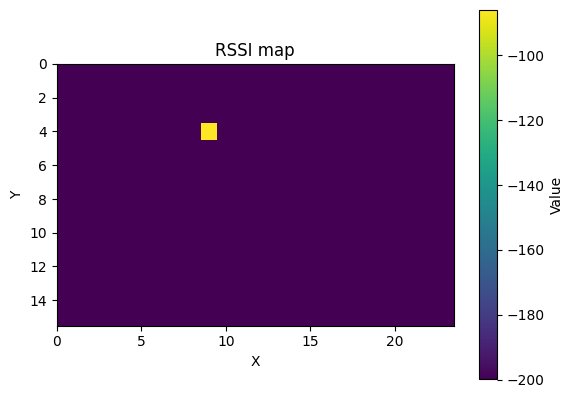

location                                                     U02
date                                         2016-10-18 11:13:59
b3001                                                       -200
b3002                                                        -86
b3003                                                       -200
b3004                                                       -200
b3005                                                       -200
b3006                                                       -200
b3007                                                       -200
b3008                                                       -200
b3009                                                       -200
b3010                                                       -200
b3011                                                       -200
b3012                                                       -200
b3013                                                       -200
coordinates              

In [48]:
visualize_obs(df['images'].iloc[171])
df.iloc[171]


Looking at the most erroneous prediction we see that this could be an outlier!

In [49]:
mean_squared_error(np.array(list(results['actual'].drop([171]))), torch.stack(list(results['fitted'].drop([171]))).numpy())


1.9979232028646399

## Conclusions

I had to solve a indoor localization problem. 

The first attempt to solve this task was using a k-NN to predict the "cell" corresponding to the actual location of the user. Using a k-NN I reached a 49% accuracy.

Than, I decided to change the data: instead of predicting the cell I tried to predict the coordinates instead. The classification task turned into a regression task. In this case I decided to apply two different Light Gradient Boost Machines. One model to predict the x coordinate and one model to predict the y coordinate, using the MSE to assess the quality of the model.

In order to improve the localization system I tried to build and use an MLP. This not only could improve the system of the model but it allow me to predict both the x and y coordinate in one model.

The MLP takes in input the 13 readings from the beacons but the model doesnt have a "geographic" knowledge of the beacons positions, so I decided to switch from a MLP to a CNN.

Convolutional Neural Networks take as input images. In this case, I transformed the feature vector into an image where the pixel corresponding to the beacon position had the value of the RSSI reading coming from that beacon. In this way the model could have the knowledge about beacons positions.

The results of the test set tell me that the idea of switching from MLP to CNN improved the localization system, however I think that is important to highlight the main pro and cons of doing so:
- The input images almost have only one (or two in few cases) pixel over 24x16 pixels that brings real information instead of 1 out of 13 from the feature vector.
- On the other hand, the position of the pixel is also important for the model. This model has also a huge benefit: in theory we could move a sensor, remove a sensor, add a sensor and we could still use the same model for the localization. This could not happen with the MLP model.

I think I reached a good result but however, it is worth to point out that there is still room to improve the system. I saw that in the test set we had a strong outlier. One can think about remove outliers also from the training set (a good strategy could be excluding positions that are far away from the beacon they are receiving the signal).

Another improvement could be switching again the model. For example we can try to use an LSTM and pass to the model not a single observation but a series of observations corresponding to a previous window of time. In this way we can exploit past positions and RSSI readings of the user to better predict the actual position.